In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

# Classification model for the "Xente Fraud Detection Challenge" 
### http://zindi.africa/competitions/xente-fraud-detection-challenge



In [0]:
# Import some necessary libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
# Load the provided training and test data into dataframes
train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/zindi/training.csv' )
test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/zindi/test.csv' )

## Data exploration and cleaning

In [0]:
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


As we are dealing with fraud data, the data is sure to be imbalanced. Therefore, we will look at the percentage of fraudulent transactions compared to the total number of transactions.

Number of fraudulent transactions:  193
Fraction of fraudulent transactions:  0.00201752001839811


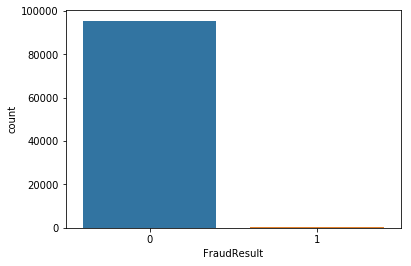

In [0]:
# Select fraudulent transactions
num_fraud = len(train[train['FraudResult'] == 1])

print('Number of fraudulent transactions: ', num_fraud)
print('Fraction of fraudulent transactions: ', num_fraud/(len(train)))

sns.countplot(train['FraudResult'])

Fraudulent transactions only make up around 0.2% of the number of transactions.

We will take a closer look at the features in the training and test sets.

In [0]:
# Check the dataframe sizes, type assignments, and missing values
print('Train info:')
train.info()
print('\nTest info:')
test.info()

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
TransactionId           95662 non-null object
BatchId                 95662 non-null object
AccountId               95662 non-null object
SubscriptionId          95662 non-null object
CustomerId              95662 non-null object
CurrencyCode            95662 non-null object
CountryCode             95662 non-null int64
ProviderId              95662 non-null object
ProductId               95662 non-null object
ProductCategory         95662 non-null object
ChannelId               95662 non-null object
Amount                  95662 non-null float64
Value                   95662 non-null int64
TransactionStartTime    95662 non-null object
PricingStrategy         95662 non-null int64
FraudResult             95662 non-null int64
dtypes: float64(1), int64(4), object(11)
memory usage: 11.7+ MB

Test info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45019 entries, 0 to 

From the training and test sets one can see that there are no missing values. There are a number of categorical features. To assess which of these might be useful, we will look at the number of unique values in each.

In [0]:
# Print number of unique values
for col in train.columns:
    print(col, len(train[col].unique()))

TransactionId 95662
BatchId 94809
AccountId 3633
SubscriptionId 3627
CustomerId 3742
CurrencyCode 1
CountryCode 1
ProviderId 6
ProductId 23
ProductCategory 9
ChannelId 4
Amount 1676
Value 1517
TransactionStartTime 94556
PricingStrategy 4
FraudResult 2


TransactionId and BatchId denote random identifiers of the transactions and can be removed. AccoutId, SubscriptionId, and CustomerId all relate to one another, thus only the most differentiated of the three will be retained. CurrencyCode and CountryCode are the same for all records and will therefore be removed.

We will combine the training and test sets in order to conduct any feature processing simultaneously and similarly.

In [0]:
# Combine datasets
combined = pd.concat([train.drop('FraudResult', axis=1), test])

# Drop selected columns
work_df = combined.drop(['TransactionId', 'BatchId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode'], axis=1)

From the dataframe information we could see that categorical feature, "PricingStrategy", is wrongly assigned as integers. Likewise, the feature denoting data and time, "TransactionStartTime" is assigned as object. We will reassign these data types to object and datetime types respectively.

Form the datetime feature, we can further separate out the day, day of the week, and hour the transactions took place. We can also assign the hour to a part of the day, such as early morning, morning, late morning, early afternoon, afternoon, late afternoon, early evening, and late evening. All these date and time features will be assigned to be of object type in order to be recognised as categorical variables.

In [0]:
# Transform data types
work_df['PricingStrategy'] = work_df['PricingStrategy'].astype(object)
work_df['TransactionStartTime'] = pd.to_datetime(work_df['TransactionStartTime'])

# Separate selected date and time features
work_df['day'] = work_df['TransactionStartTime'].dt.day
work_df['hour'] = work_df['TransactionStartTime'].dt.hour
work_df['week_day'] = work_df['TransactionStartTime'].dt.dayofweek

In [0]:
# Assign hour to time of day
def tod(t):
  
    """Assign a time of day to an hour t.
    Args:
      t (int): hour
    Returns:
      various (str): time of day category
    """
  
    if t >= 0 and t < 3:
        return 'early_morning'
    elif t >= 3 and t < 6:
        return 'morning'
    elif t >= 6 and t < 9:
        return 'late_morning'
    elif t >= 9 and t < 12:
        return 'early_afternoon'
    elif t >= 12 and t < 15:
        return 'afternoon'
    elif t >= 15 and t < 18:
        return 'late_afternoon'
    elif t >= 18 and t < 21:
        return 'early_evening'
    elif t >= 21:
        return 'late_evening'
    return 'other'
  
work_df['time_day'] = work_df['hour'].apply(lambda row: tod(row))

In [0]:
# Set data types
work_df['day'] = work_df['day'].astype(object)
work_df['hour'] = work_df['hour'].astype(object)
work_df['week_day'] = work_df['week_day'].astype(object)

In order to assess if the limited fraudulent transactions have recognisable trends, we will examine them separately.

In [0]:
# Select fraudulent transactions
fraud = pd.concat([work_df.iloc[:len(train)], train['FraudResult']], axis=1)

fraud = fraud[fraud['FraudResult'] == 1]
fraud.describe()

,Amount,Value,FraudResult
count,1.930000e+02,1.930000e+02,193.0
mean,1.535272e+06,1.561820e+06,1.0
std,2.100525e+06,2.081227e+06,0.0
min,-9.000000e+05,5.000000e+02,1.0
25%,5.000000e+05,5.000000e+05,1.0
50%,6.000000e+05,6.500000e+05,1.0
75%,2.000000e+06,2.000000e+06,1.0
max,9.880000e+06,9.880000e+06,1.0


In [0]:
# Get number of unique values for each feature
for col in fraud.columns:
  print(col, len(fraud[col].unique()))

AccountId 52
ProviderId 5
ProductId 9
ProductCategory 4
ChannelId 3
Amount 61
Value 61
TransactionStartTime 193
PricingStrategy 4
day 30
hour 20
week_day 7
time_day 8
FraudResult 1


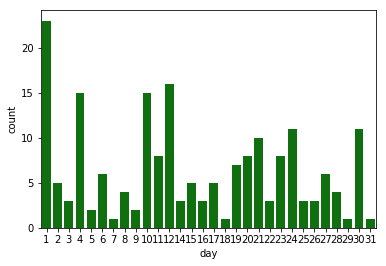

In [0]:
sns.countplot(fraud['day'], color='green')

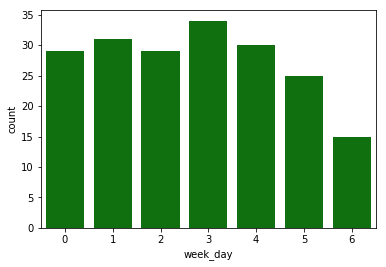

In [0]:
sns.countplot(fraud['week_day'], color='green')

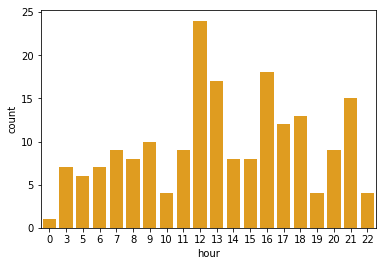

In [0]:
sns.countplot(fraud['hour'], color='orange')

We thus see that the date and time will not offer much distinction, as fraudulent transactions takes place across all different days and times. Also, as 'Value' represents the absolute of 'Amount',  we will only include one of them as feature, and will then only include 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Value', and 'PricingStrategy' as features.

As the different ID's and product categories are nominal categorical features, they will be converted to dummy variables before separating the training and test sets again.

In [0]:
dummies = work_df[['ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Value', 'PricingStrategy']]
dummies = pd.get_dummies(dummies, drop_first=True)

dummies.shape

(140681, 48)

In [0]:
train_dum = dummies.iloc[: len(train)]
test_dum = dummies.iloc[len(train):]

## Model imports and function

Since we are aiming to identify fraud, we will investigate using the random forest and k-nearest neighbours classifiers to predict wheather a transaction is fraudulent or not.


In [0]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

To optimise the f1-score as per competition assignment, we need to look at altering the precision and recall of the predictions. We will do this by investigating a range of probability thresholds. To aid the investigations, we will define a model building function that would train the specified model and provide the resultant predicted probabilities for the training and test sets.

In [0]:
# Define model building function
def build_model(train_X, test_X, train_y, test_y, model):
  
    """Split data into training and test sets, fit the specified model, and make probability and label predictions.
    Args:
        X (array or DataFrame): independent variables
        y (array or DataFrame): dependent variable
        model (model): sklearn model and parameters
    Returns:
        train_pred (array): label predictions from training data 
        test_pred (array): label predictions from test data
        train_proba (array): probability predictions from training data 
        test_proba (array): probability predictions from test data
    """
    
    model.fit(train_X, train_y)

    train_pred = model.predict(train_X)
    test_pred = model.predict(test_X)
    
    train_proba = model.predict_proba(train_X)
    test_proba = model.predict_proba(test_X)
    
    return train_pred, test_pred, train_proba, test_proba

##  RF with hold-out set

In [0]:
train_fraud = pd.concat([train_dum, train['FraudResult']], axis=1)

train_fraud.shape

(95662, 49)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_fraud.drop('FraudResult', axis=1), train_fraud['FraudResult'], random_state=11)

print(X_train.shape)
print(X_test.shape)

(71746, 48)
(23916, 48)


In [0]:
cm = RandomForestClassifier(n_estimators=50, max_depth=3, max_features='auto', bootstrap=False, n_jobs=-1, random_state=11)

pred_train, pred_test, proba_train, proba_test = build_model(X_train, X_test, y_train, y_test, cm)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0, 0.5, 'f1 score')

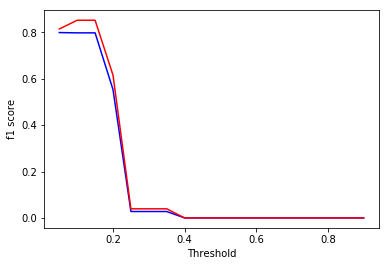

In [0]:
frac = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
train_f1 = []
test_f1 = []

for f in frac:
    y_train_th = np.where(proba_train[:,1] > f, 1, 0)
    train_f1.append(f1_score(y_train, y_train_th))
    y_test_th = np.where(proba_test[:,1] > f, 1, 0)
    test_f1.append(f1_score(y_test, y_test_th))
    
sns.lineplot(x=frac, y=train_f1, color='blue')
sns.lineplot(x=frac, y=test_f1, color='red')
plt.xlabel('Threshold\nTrain: blue; Test: red')
plt.ylabel('f1 score')

In [0]:
best = np.argmax(test_f1)
pred_test_best = np.where(proba_test[:,1] > frac[best], 1, 0)

print('Threshold: ', frac[best])
print('f1 score: ', test_f1[best])
print('Confusion matrix:')
print(confusion_matrix(y_test, pred_test_best))

Threshold:  0.1
f1 score:  0.851851851851852
Confusion matrix:
[[23854    12]
 [    4    46]]


##  RF using all training data


In [0]:
cm = RandomForestClassifier(n_estimators=50, max_depth=3, max_features='auto', bootstrap=False, n_jobs=-1, random_state=11)

cm.fit(train_dum, train['FraudResult'])

pred_train = cm.predict(train_dum)
pred_test = cm.predict(test_dum)
    
proba_train = cm.predict_proba(train_dum)
proba_test = cm.predict_proba(test_dum)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0, 0.5, 'f1 score')

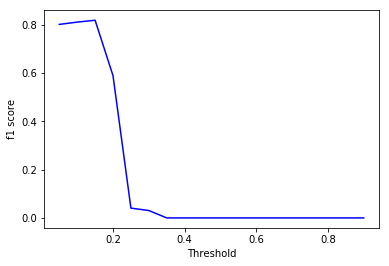

In [0]:
frac = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
train_f1 = []

for f in frac:
    y_train_th = np.where(proba_train[:,1] > f, 1, 0)
    train_f1.append(f1_score(train['FraudResult'], y_train_th))
    
sns.lineplot(x=frac, y=train_f1, color='blue')
plt.xlabel('Threshold')
plt.ylabel('f1 score')

In [0]:
y_thresh = np.where(proba_test[:,1] > 0.15, 1, 0)
y_thresh

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
results = test[['TransactionId']]
results['FraudResult'] = y_thresh

In [0]:
# results.to_csv('/content/gdrive/My Drive/Colab Notebooks/zindi/RF_50_3_auto_0-15_time.csv', index=False)

##  KNN with hold-out set

In [0]:
train_fraud = pd.concat([train_dum, train['FraudResult']], axis=1)

train_fraud.shape

(95662, 49)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_fraud.drop('FraudResult', axis=1), train_fraud['FraudResult'], random_state=11)

print(X_train.shape)
print(X_test.shape)

(71746, 48)
(23916, 48)


In [0]:
cm = KNeighborsClassifier(n_neighbors=7, weights='distance', algorithm='auto', n_jobs=-1)

pred_train, pred_test, proba_train, proba_test = build_model(X_train, X_test, y_train, y_test, cm)


Text(0, 0.5, 'f1 score')

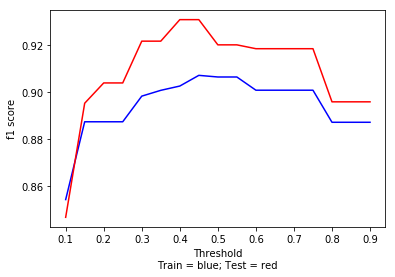

In [0]:
frac = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
train_f1 = []
test_f1 = []

for f in frac:
    y_train_th = np.where(proba_train[:,1] > f, 1, 0)
    train_f1.append(f1_score(y_train, y_train_th))
    y_test_th = np.where(proba_test[:,1] > f, 1, 0)
    test_f1.append(f1_score(y_test, y_test_th))
    
sns.lineplot(x=frac, y=train_f1, color='blue')
sns.lineplot(x=frac, y=test_f1, color='red')
plt.xlabel('Threshold\nTrain = blue; Test = red')
plt.ylabel('f1 score')

In [0]:
best = np.argmax(test_f1)
pred_test_best = np.where(proba_test[:,1] > frac[best], 1, 0)

print('Threshold: ', frac[best])
print('f1 score: ', test_f1[best])
print('Confusion matrix:')
print(confusion_matrix(y_test, pred_test_best))

Threshold:  0.4
f1 score:  0.9306930693069307
Confusion matrix:
[[23862     4]
 [    3    47]]


##  KNN using all training data


In [0]:
cm = KNeighborsClassifier(n_neighbors=7, weights='distance', algorithm='auto', n_jobs=-1)

cm.fit(train_dum, train['FraudResult'])

pred_train = cm.predict(train_dum)
pred_test = cm.predict(test_dum)
    
proba_train = cm.predict_proba(train_dum)
proba_test = cm.predict_proba(test_dum)

Text(0, 0.5, 'f1 score')

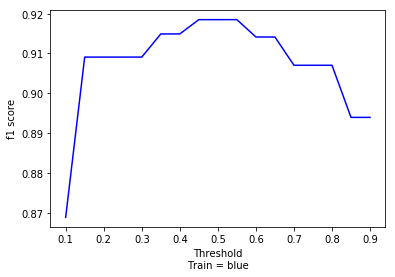

In [0]:
frac = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
train_f1 = []

for f in frac:
    y_train_th = np.where(proba_train[:,1] > f, 1, 0)
    train_f1.append(f1_score(train['FraudResult'], y_train_th))
    
sns.lineplot(x=frac, y=train_f1, color='blue')
plt.xlabel('Threshold\nTrain = blue')
plt.ylabel('f1 score')

In [0]:
y_thresh = np.where(proba_test[:,1] > 0.4, 1, 0)
y_thresh

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
results = test[['TransactionId']]

In [0]:
results['FraudResult'] = y_thresh

results.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,TransactionId,FraudResult
0,TransactionId_50600,0
1,TransactionId_95109,0
2,TransactionId_47357,0
3,TransactionId_28185,0
4,TransactionId_22140,0


In [0]:
# results.to_csv('/content/gdrive/My Drive/Colab Notebooks/zindi/KNN_7_distance_auto_0-4_time.csv', index=False)